In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

import itertools

## Preparation

In [2]:
path_to_dataset = Path('Downloads/Telegram Desktop/transactions.csv')
path_to_dataset.exists()

True

In [3]:
df = pd.read_csv(path_to_dataset)
df.head()

,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86506,50.00,0.0,NaN,NaN,4497,514.0,150.0,420.0,87.0,0.0,0.0,0.0
1,0,86761,39.00,0.0,NaN,NaN,7875,314.0,150.0,299.0,87.0,0.0,0.0,0.0
2,0,86821,73.95,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
3,0,87135,107.95,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
4,0,87557,35.95,0.0,NaN,NaN,9785,343.0,150.0,485.0,87.0,0.0,0.0,0.0


In [4]:
df = df.fillna(0)
df.head()

,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86506,50.00,0.0,0.0,0.0,4497,514.0,150.0,420.0,87.0,0.0,0.0,0.0
1,0,86761,39.00,0.0,0.0,0.0,7875,314.0,150.0,299.0,87.0,0.0,0.0,0.0
2,0,86821,73.95,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
3,0,87135,107.95,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
4,0,87557,35.95,0.0,0.0,0.0,9785,343.0,150.0,485.0,87.0,0.0,0.0,0.0


In [5]:
X = df.drop(columns='addr1 D3 V106'.split(' '))
X

,isFraud,TransactionDT,TransactionAmt,D1,D2,card1,card2,card3,addr2,V104,V105
0,0,86506,50.000,0.0,0.0,4497,514.0,150.0,87.0,0.0,0.0
1,0,86761,39.000,0.0,0.0,7875,314.0,150.0,87.0,0.0,0.0
2,0,86821,73.950,66.0,66.0,10112,360.0,150.0,87.0,0.0,0.0
3,0,87135,107.950,245.0,245.0,17359,555.0,150.0,87.0,0.0,0.0
4,0,87557,35.950,0.0,0.0,9785,343.0,150.0,87.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
59049,0,15810350,92.000,3.0,3.0,2377,203.0,150.0,87.0,0.0,0.0
59050,0,15810372,117.000,472.0,471.0,12873,535.0,150.0,87.0,0.0,0.0
59051,0,15810912,73.838,0.0,0.0,5096,555.0,185.0,0.0,0.0,0.0
59052,0,15811007,204.970,315.0,315.0,12037,595.0,150.0,87.0,0.0,0.0


In [6]:
Y = df['addr1']
Y.head()

0    420.0
1    299.0
2    264.0
3    469.0
4    485.0
Name: addr1, dtype: float64

## Step 1

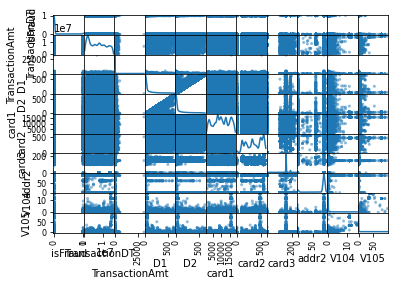

In [7]:
pd.plotting.scatter_matrix(X, diagonal="kde")
plt.show()

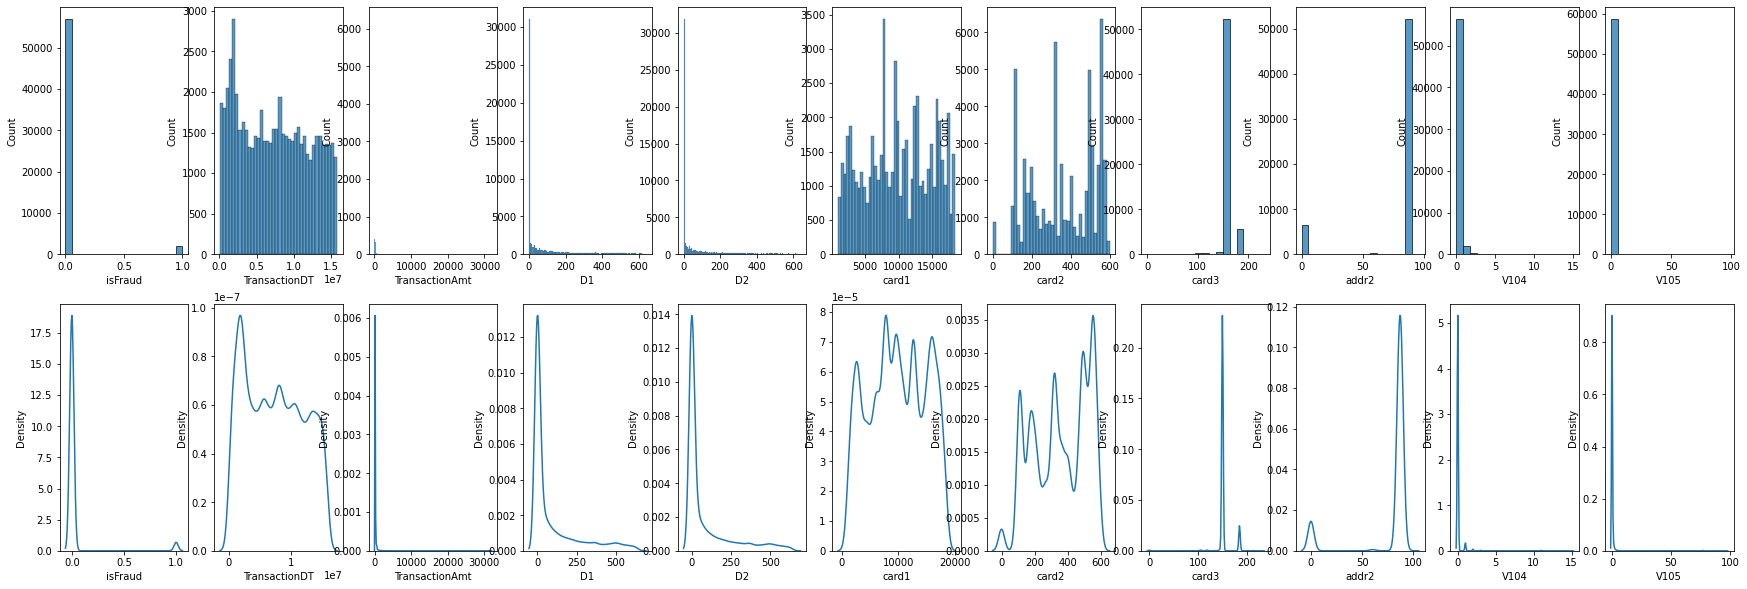

In [8]:
fig, axes = plt.subplots(2, X.shape[1], figsize=(30,10))
index_products = itertools.product(range(2), range(X.shape[1]))
iter1, iter2 = itertools.tee(X.columns)
for column, product in zip(itertools.chain(iter1, iter2), index_products):
    x, y = product
    if x == 0:
        sns.histplot(ax=axes[x][y], data=X[column])
    else:
        sns.kdeplot(ax=axes[x][y], data=X[column])

## Step 2

Mathematical Expectation for X

In [9]:

X.apply(np.mean)

isFraud           3.478173e-02
TransactionDT     7.346077e+06
TransactionAmt    1.358500e+02
D1                9.396270e+01
D2                8.893652e+01
card1             9.896024e+03
card2             3.571517e+02
card3             1.527605e+02
addr2             7.723782e+01
V104              8.405866e-02
V105              2.828936e-01
dtype: float64

Variance for X

In [10]:

X.apply(np.std)

isFraud           1.832265e-01
TransactionDT     4.611105e+06
TransactionAmt    2.688325e+02
D1                1.578414e+02
D2                1.541379e+02
card1             4.887647e+03
card2             1.626918e+02
card3             1.368990e+01
addr2             2.731229e+01
V104              6.422743e-01
V105              3.433044e+00
dtype: float64

## Step 3

In [11]:
non_parametric_data = {column: {} for column in X.columns}
for column, data in zip(X.columns, non_parametric_data.values()):
    data['ME'] = np.mean(X[column])
    data['Variance'] = np.std(X[column])
    
    
non_parametric = pd.DataFrame(non_parametric_data)
non_parametric

,isFraud,TransactionDT,TransactionAmt,D1,D2,card1,card2,card3,addr2,V104,V105
ME,0.034782,7.346077e+06,135.849976,93.962695,88.936516,9896.023843,357.151742,152.760473,77.237816,0.084059,0.282894
Variance,0.183227,4.611105e+06,268.832454,157.841383,154.137928,4887.647117,162.691849,13.689895,27.312294,0.642274,3.433044


## Step 4

We need combinations to produce each pair of features

In [12]:
pairs = itertools.combinations(X.columns, 2)
statistics_data = {pair: {} for pair in pairs}


def count_confidence_interval(fst, snd):
    r, p = stats.pearsonr(fst, snd)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1 / np.sqrt(fst.size - 3)
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    return lo_z, hi_z


for pair, data in statistics_data.items():
    column1, column2 = pair
    data['pair correlation'], p_value = stats.pearsonr(X[column1], X[column2])
    lower, higher = count_confidence_interval(X[column1], X[column2])
    data['lower confidence interval'] = f'{lower:.6f}' 
    data['higher confidence interval'] = f'{higher:.6f}'
    data['significance level'] = f'{p_value:.6f}'
    
statistics_df = pd.DataFrame(data=statistics_data)
statistics_df = statistics_df.T
statistics_df

pair correlation lower confidence interval  \
isFraud        TransactionDT          0.012598                  0.004533   
               TransactionAmt         0.013163                  0.005099   
               D1                    -0.068868                 -0.077043   
               D2                    -0.075137                 -0.083344   
               card1                 -0.007578                 -0.015644   
               card2                 -0.000575                 -0.008641   
               card3                  0.131764                  0.124469   
               addr2                  -0.16396                 -0.173519   
               V104                   0.004942                 -0.003124   
               V105                  -0.003313                 -0.011379   
TransactionDT  TransactionAmt         0.010422                  0.002356   
               D1                     0.072091                  0.064151   
               D2                     0.068981                  0.061025   
               card1                  0.014605                  0.006540   
               card2                 -0.014961                 -0.023027   
               card3                 -0.028773                 -0.036846   
               addr2                  0.002892                 -0.005174   
               V104                   0.072549                  0.064611   
               V105                   0.077678                  0.069769   
TransactionAmt D1                     -0.03463                 -0.042709   
               D2                    -0.037531                 -0.045614   
               card1                  -0.00866                 -0.016726   
               card2                  0.009187                  0.001122   
               card3                  -0.08262                 -0.090874   
               addr2                  0.122805                  0.115362   
               V104                   0.021345                  0.013283   
               V105                  -0.000973                 -0.009039   
D1             D2                     0.974136                  2.159447   
               card1                  -0.00771                 -0.015776   
               card2                  0.013307                  0.005242   
               card3                 -0.088479                 -0.096776   
               addr2                  0.139759                  0.132614   
               V104                  -0.021266                 -0.029334   
               V105                  -0.004646                 -0.012711   
D2             card1                 -0.008955                 -0.017021   
               card2                  0.009797                  0.001731   
               card3                 -0.091103                 -0.099422   
               addr2                  0.144589                  0.137544   
               V104                  -0.021491                 -0.029560   
               V105                  -0.004265                 -0.012330   
card1          card2                  0.010108                  0.002043   
               card3                 -0.003689                 -0.011755   
               addr2                  0.004884                 -0.003181   
               V104                   0.050426                  0.042404   
               V105                   0.055463                  0.047454   
card2          card3                  0.082867                  0.074992   
               addr2                 -0.055005                 -0.063126   
               V104                   0.039774                  0.031730   
               V105                   0.036347                  0.028298   
card3          addr2                 -0.630745                 -0.750718   
               V104                  -0.021125                 -0.029194   
               V105                  -0.017507                 -0.025574   
ad

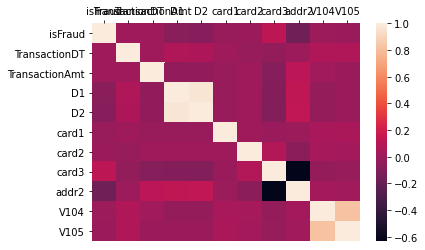

In [13]:
corrmat = X.corr()
sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

## Step 5

Lets look at the target value

<AxesSubplot:xlabel='addr1', ylabel='Count'>

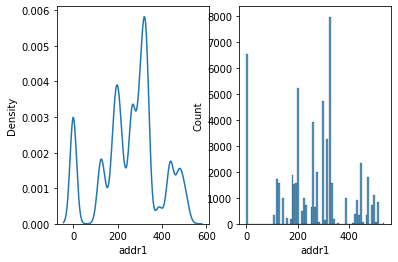

In [14]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(ax=axes[0], data=Y)
sns.histplot(ax=axes[1], data=Y)

Then lets estimate the multivariate correlation of target variable with predictors

In [15]:
correlations = {}

for column in X.columns:
    corr, _ = stats.pearsonr(Y, X[column])
    correlations[column] = corr
    
df = pd.DataFrame(correlations, index=['Correlation with target'])
df

,isFraud,TransactionDT,TransactionAmt,D1,D2,card1,card2,card3,addr2,V104,V105
Correlation with target,-0.107227,0.002169,0.077173,0.098369,0.101298,0.017143,-0.019797,-0.431896,0.68615,0.032813,0.026971


## Step 6

Lets build a regression model like we usually do. First, our dataset is split on train and test samples.

In [16]:
X_new = X[['TransactionAmt', 'D2', 'addr2']]
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.33, random_state=42)

Next lets train a regression model

In [17]:
reg = LinearRegression(normalize=True)

reg.fit(X_train, y_train)

LinearRegression(normalize=True)

Then lets visualize the results:

<AxesSubplot:ylabel='addr1'>

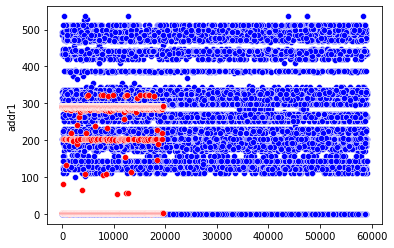

In [18]:
y_pred = reg.predict(X_test)
y_pred_all = reg.predict(X_new)

sns.scatterplot(data=y_test, color='b')
sns.scatterplot(data=y_pred, color='r')

Посмотрим на метрики:

In [19]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.5f}')
print(f'Mean Square Error: {mse:.5f}')

Mean Absolute Error: 72.44615
Mean Square Error: 9290.56714


In [35]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
scaler = StandardScaler()
Y_new = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape((-1, 1))))

X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.4, random_state=42)

poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new_poly = poly.fit_transform(X_new)
y_pred_poly_all = reg.predict(X_new_poly)

Text(0, 0.5, 'pdays')

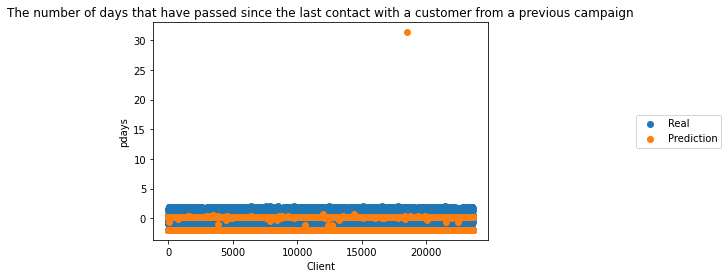

In [37]:
plt.scatter([i for i in range(len(X_test))], y_test, label = u'Real')
plt.scatter([i for i in range(len(X_test))], y_pred_poly, label = u'Prediction')
plt.title(u'The number of days that have passed since the last contact with a customer from a previous campaign')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))
plt.xlabel(u'Client')
plt.ylabel('pdays')

In [38]:
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print('Mean absolute error with Polynomial model = ', mae_poly)
print('Mean squared error with Polynomial model = ', mse_poly)

Mean absolute error with Polynomial model =  0.5471988366925269
Mean squared error with Polynomial model =  0.5695564436299092


## Step 7

Lets plot the distribution of residuals

<AxesSubplot:ylabel='Count'>

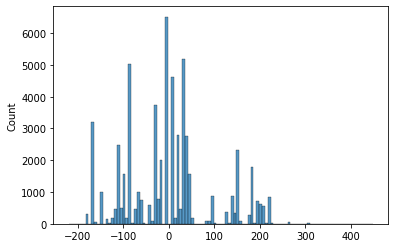

In [39]:
y1 = np.array(Y)
y2 = np.array(y_pred_all)
y_diff = y1 - y2
sns.histplot(y_diff, kde=False)

Lets count determination coefficient on the test samples

In [40]:
r2 = r2_score(y_test, y_pred_poly)

In [41]:
r2

0.43124271344177234